In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**I first trained the neural network on the training set alone. Then a thought occured that why don't I use the test set to train as well. So here I am concatenating both the train and test set and one-hot encoding it**

In [29]:
def load_data(csv_path):
    data = pd.read_csv(csv_path).values
    labels = data[:, 0]  
    images = data[:, 1:] / 255.0  
    
    num_classes = 47
    labels_one_hot = np.zeros((labels.size, num_classes))
    labels_one_hot[np.arange(labels.size), labels] = 1
    
    return images, labels_one_hot, labels


train_images, train_labels_one_hot, train_labels = load_data('/kaggle/input/emnist/emnist-balanced-train.csv')
test_images, test_labels_one_hot, test_labels = load_data('/kaggle/input/emnist/emnist-balanced-test.csv')

#Here I am concatenating both the train and test set
combined_images = np.concatenate((train_images, test_images), axis=0)
combined_labels = np.concatenate((train_labels, test_labels), axis=0)
combined_labels_one_hot = np.concatenate((train_labels_one_hot, test_labels_one_hot), axis=0)

**Initialising Parameters for the Neural Network**

In [30]:
def initialize_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W_skip = np.random.randn(input_size, hidden_size) * 0.01 
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    return W1, b1, W_skip, W2, b2

**Activation functions**

In [31]:
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

**Propagation Functions**

In [32]:
def forward_propagation(X, W1, b1, W_skip, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)    
    skip_out = np.dot(X, W_skip)  
    A1 += skip_out      
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_propagation(X, Y_true, Z1, A1, Z2, A2, W1, b1, W_skip, W2, b2, learning_rate):
    m = X.shape[0]
    dZ2 = A2 - Y_true
    dW2 = (1/m) * np.dot(A1.T, dZ2)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (Z1 > 0)    
    dW1 = (1/m) * np.dot(X.T, dZ1)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
    dW_skip = (1/m) * np.dot(X.T, dA1)      
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    W_skip -= learning_rate * dW_skip    
    return W1, b1, W_skip, W2, b2

**Defining Metrics**

In [33]:
def accuracy(Y_true, Y_pred):
    return np.mean(Y_true == Y_pred)

def precision(Y_true, Y_pred):
    return np.mean([np.sum((Y_pred == c) & (Y_true == c)) / (np.sum(Y_pred == c) + 1e-9) for c in np.unique(Y_true)])

def recall(Y_true, Y_pred):
    return np.mean([np.sum((Y_pred == c) & (Y_true == c)) / (np.sum(Y_true == c) + 1e-9) for c in np.unique(Y_true)])

def f1_score(Y_true, Y_pred):
    prec, rec = precision(Y_true, Y_pred), recall(Y_true, Y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-9)

def log_loss(Y_true, Y_pred_prob):
    return -np.mean(np.log(Y_pred_prob[np.arange(len(Y_true)), Y_true] + 1e-9))

def specificity(Y_true, Y_pred):
    return np.mean([np.sum((Y_pred != c) & (Y_true != c)) / (np.sum(Y_true != c) + 1e-9) for c in np.unique(Y_true)])

def auc_binary(y_true, y_scores):
    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos
    if n_pos == 0 or n_neg == 0:
        return 0.5
    order = np.argsort(y_scores)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(y_scores) + 1)
    sum_ranks_pos = np.sum(ranks[y_true == 1])
    auc_val = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
    return auc_val

def auc_multiclass(Y_true, Y_pred_prob, num_classes):
    aucs = []
    for c in range(num_classes):
        binary_true = (Y_true == c).astype(int)
        auc_val = auc_binary(binary_true, Y_pred_prob[:, c])
        aucs.append(auc_val)
    return np.mean(aucs)

**I wrote this function to reset weights so the weights reset when I'm retraining after changing the parameters**

In [34]:
def reset_weights():
    global W1, b1, W_skip, W2, b2
    W1, b1, W_skip, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

In [35]:
epochs=50
batch_size = 16
learning_rate = 0.01

input_size, hidden_size, output_size = 784, 256, 47
W1, b1, W_skip, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

train_metrics_log = []  
test_metrics_log = []   

reset_weights()  

for epoch in range(epochs):    
    for i in range(0, len(combined_images), batch_size):
        X_batch = combined_images[i:i+batch_size]
        Y_batch = combined_labels_one_hot[i:i+batch_size]
        
        Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W_skip, W2, b2)
        W1, b1, W_skip, W2, b2 = backward_propagation(X_batch, Y_batch, Z1, A1, Z2, A2, W1, b1, W_skip, W2, b2, learning_rate)
    
    # Evaluating on the combined training set
    _, _, _, train_pred_prob = forward_propagation(combined_images, W1, b1, W_skip, W2, b2)
    train_pred = np.argmax(train_pred_prob, axis=1)
    train_acc = accuracy(combined_labels, train_pred)
    train_prec = precision(combined_labels, train_pred)
    train_rec = recall(combined_labels, train_pred)
    train_f1 = f1_score(combined_labels, train_pred)
    train_ll = log_loss(combined_labels, train_pred_prob)
    train_spec = specificity(combined_labels, train_pred)
    train_auc = auc_multiclass(combined_labels, train_pred_prob, output_size)
    train_metrics_log.append([train_acc, train_prec, train_rec, train_f1, train_ll, train_spec, train_auc])
    
    # Evaluating on the original test set
    _, _, _, test_pred_prob = forward_propagation(test_images, W1, b1, W_skip, W2, b2)
    test_pred = np.argmax(test_pred_prob, axis=1)
    test_acc = accuracy(test_labels, test_pred)
    test_prec = precision(test_labels, test_pred)
    test_rec = recall(test_labels, test_pred)
    test_f1 = f1_score(test_labels, test_pred)
    test_ll = log_loss(test_labels, test_pred_prob)
    test_spec = specificity(test_labels, test_pred)
    test_auc = auc_multiclass(test_labels, test_pred_prob, output_size)
    test_metrics_log.append([test_acc, test_prec, test_rec, test_f1, test_ll, test_spec, test_auc])
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Combined Train - Acc: {train_acc*100:.2f}%, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}, LogLoss: {train_ll:.4f}, Spec: {train_spec:.4f}, AUC: {train_auc:.4f}")
    print(f"Original Test - Acc: {test_acc*100:.2f}%, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}, LogLoss: {test_ll:.4f}, Spec: {test_spec:.4f}, AUC: {test_auc:.4f}\n")
    
    if epoch % 10 == 0 and epoch > 0:
        learning_rate *= 0.9

Epoch 1/50
Combined Train - Acc: 65.59%, Prec: 0.6555, Rec: 0.6559, F1: 0.6557, LogLoss: 1.2413, Spec: 0.9925, AUC: 0.9746
Original Test - Acc: 65.46%, Prec: 0.6537, Rec: 0.6546, F1: 0.6541, LogLoss: 1.2347, Spec: 0.9925, AUC: 0.9748

Epoch 2/50
Combined Train - Acc: 70.75%, Prec: 0.7085, Rec: 0.7075, F1: 0.7080, LogLoss: 1.0503, Spec: 0.9936, AUC: 0.9814
Original Test - Acc: 71.01%, Prec: 0.7107, Rec: 0.7101, F1: 0.7104, LogLoss: 1.0461, Spec: 0.9937, AUC: 0.9814

Epoch 3/50
Combined Train - Acc: 74.85%, Prec: 0.7498, Rec: 0.7485, F1: 0.7492, LogLoss: 0.8917, Spec: 0.9945, AUC: 0.9865
Original Test - Acc: 75.18%, Prec: 0.7528, Rec: 0.7518, F1: 0.7523, LogLoss: 0.8887, Spec: 0.9946, AUC: 0.9864

Epoch 4/50
Combined Train - Acc: 77.57%, Prec: 0.7771, Rec: 0.7757, F1: 0.7764, LogLoss: 0.7793, Spec: 0.9951, AUC: 0.9896
Original Test - Acc: 77.89%, Prec: 0.7802, Rec: 0.7789, F1: 0.7796, LogLoss: 0.7759, Spec: 0.9952, AUC: 0.9894

Epoch 5/50
Combined Train - Acc: 79.43%, Prec: 0.7958, Rec: 

# Final test metrics

In [36]:
_, _, _, final_test_pred_prob = forward_propagation(test_images, W1, b1, W_skip, W2, b2)
final_test_pred = np.argmax(final_test_pred_prob, axis=1)
final_test_acc = accuracy(test_labels, final_test_pred)
final_test_prec = precision(test_labels, final_test_pred)
final_test_rec = recall(test_labels, final_test_pred)
final_test_f1 = f1_score(test_labels, final_test_pred)
final_test_ll = log_loss(test_labels, final_test_pred_prob)
final_test_spec = specificity(test_labels, final_test_pred)
final_test_auc = auc_multiclass(test_labels, final_test_pred_prob, output_size)

print('Final Test Set Metrics:')
print(f"Accuracy: {final_test_acc*100:.2f}%")
print(f"Precision: {final_test_prec:.4f}")
print(f"Recall: {final_test_rec:.4f}")
print(f"F1 Score: {final_test_f1:.4f}")
print(f"Log Loss: {final_test_ll:.4f}")
print(f"Specificity: {final_test_spec:.4f}")
print(f"AUC-ROC: {final_test_auc:.4f}")

Final Test Set Metrics:
Accuracy: 90.69%
Precision: 0.9080
Recall: 0.9069
F1 Score: 0.9074
Log Loss: 0.2819
Specificity: 0.9980
AUC-ROC: 0.9982


**Visualing the Various Metrics**

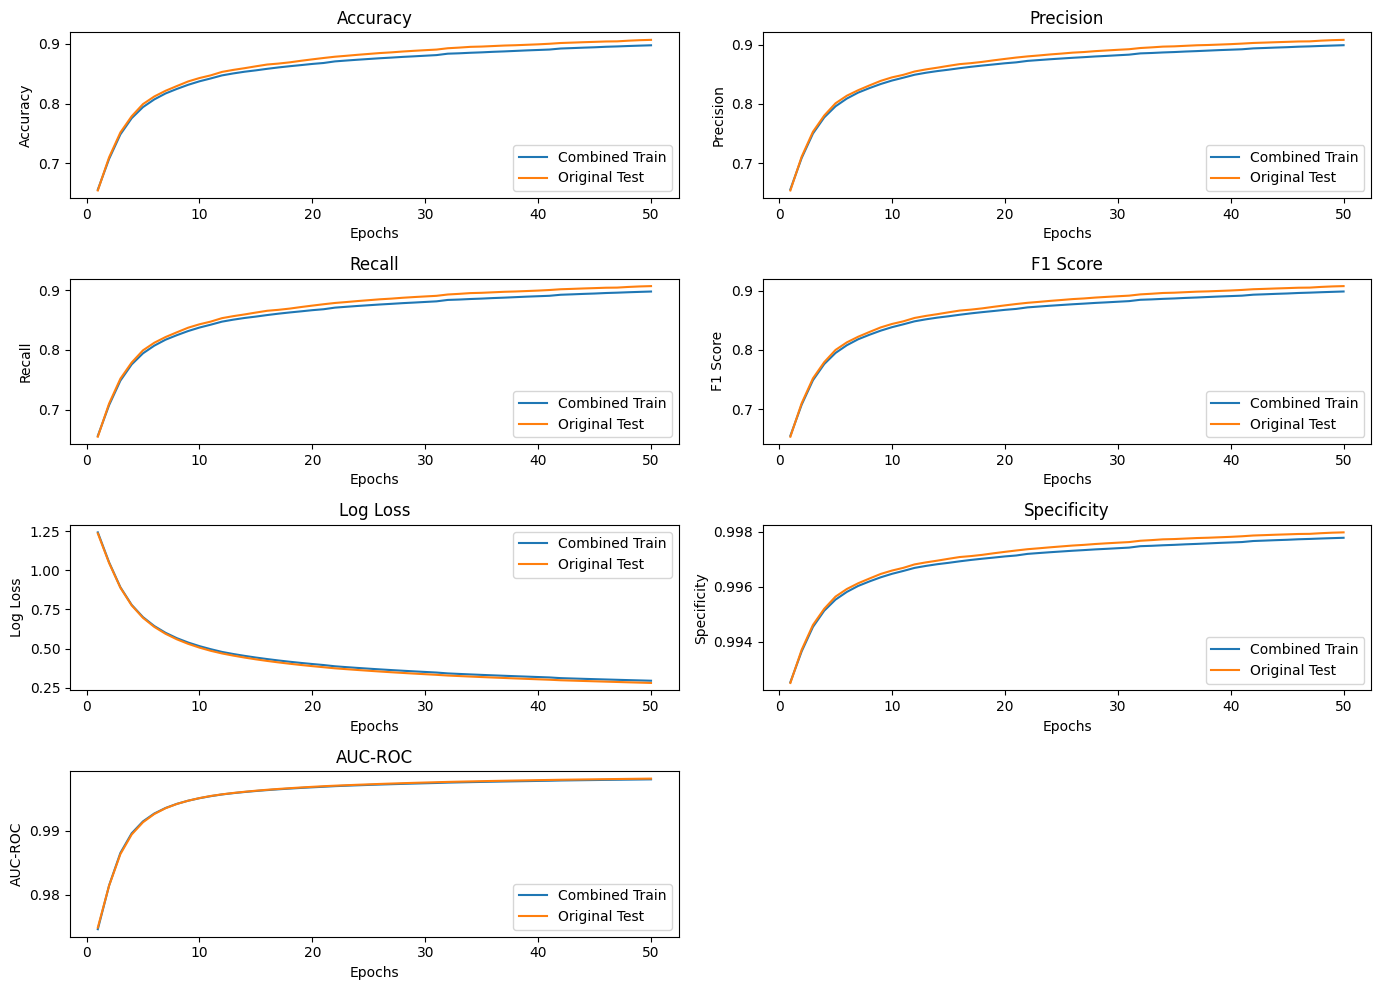

In [37]:
train_metrics_log = np.array(train_metrics_log)  # shape (epochs, 7)
test_metrics_log = np.array(test_metrics_log)
epochs_range = np.arange(1, epochs+1)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Log Loss', 'Specificity', 'AUC-ROC']

plt.figure(figsize=(14, 10))
for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.plot(epochs_range, train_metrics_log[:, i], label='Combined Train')
    plt.plot(epochs_range, test_metrics_log[:, i], label='Original Test')
    plt.title(metrics_names[i])
    plt.xlabel('Epochs')
    plt.ylabel(metrics_names[i])
    plt.legend()
plt.tight_layout()
plt.show()